# ASME Autodesk Hackathon 2023

### Notebook 2: Feature engineering and dataset investigation

- __Data Loading__: Start by loading and reading the provided JSON file to understand the data structure and contents. This includes:
    - Read the name of each body in the train assemblies, and also expand to read other information about the bodies, like their volume or corresponding image/STEP files
    - Read the ground truth material of each body
- __Feature Engineering__: make full use of different features. The JSON file contains nested structures. We need to extract relevant features like volume, body name, area, physical_properties, etc. for each part.
- __Data Transformation__: Convert the extracted features into a format suitable for feeding into a machine learning model, i.e., a tabular form where each row represents a part and columns represent the feature.
- Create a __train/validation split__s.

## Setup

In [1]:
import os
from pathlib import Path
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import backoff
import time
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

# Where to save the figures, and dataset locations
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images")
Feature_PATH = os.path.join(PROJECT_ROOT_DIR, "feature_extraction")

os.makedirs(IMAGE_PATH, exist_ok=True)
os.makedirs(Feature_PATH, exist_ok=True)

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Read file and get the target output (material category)

In [3]:
def get_all_files(directory, pattern):
    return [f for f in Path(directory).glob(pattern)]

In [4]:
def id2name(id):
    id = id.lower()
    # id = id.rstrip()
    if id == 'metal_non-ferrous':
        return 'non-ferrous metal'
    elif id == 'metal_ferrous':
        return 'ferrous metal'
    elif id == 'metal_ferrous_steel':
        return 'steel'
    elif id == 'metal_aluminum':
        return 'aluminum'
    elif id in ['other', 'wood', 'plastic']:
        return id
    else:
        raise f"Non-default id! {id}"
        # return 'other'

In [5]:
def plot_data_distribution(data, variable, title, filename):
    # Initialize the plot
    plt.figure(figsize = (7,6))
    
    # Create the countplot
    ax = sns.countplot(x=variable, data=data, palette='Set1', saturation=0.7, edgecolor='k', linewidth=1.5)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    
    # Set labels and title
    ax.set_title(title, fontsize=18, pad=14)
    ax.set_xlabel(variable, fontsize=20, labelpad=12)
    ax.set_ylabel("Data volume", fontsize=20, labelpad=10)
    ax.tick_params(labelsize=15)
    
    # Save the figure
    plt.tight_layout()
    plt.savefig(f"{filename}.png", format='png')
    plt.show()

# Example usage (you can run this in your local environment):
# plot_data_distribution(consolidated_dataset, 'material_category', 'Distribution of Fusion Galery Dataset per category', 'dataset')

In [6]:
def show_confusion_matrix(y_true, y_pred, classes=None, normalize=None):
    cm = confusion_matrix(y_true, y_pred, normalize=normalize, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(xticks_rotation=45)
    plt.tight_layout()
    plt.show()

## Read the material and names of bodies in assemlies
Loop through each of the 'assembly.json' files in the dataset, and read the name and material_categeory of each body in the assembly.
As some bodies do not have a custom name, but the default name 'body#', we will filter those out as our LLM baseline cannot predict those.

### Inspect an individual json file

In [7]:
# Load and inspect the contents of the provided assembly.json file again
with open("D:\Dataset\\ASME-Hackathon-2023-Autodesk\\train_data\\Fusion360GalleryDataset_23hackathon_train\\7780_6c885e81\\assembly.json", "r") as file:
    assembly_data = json.load(file)

In [8]:
# Display some key-value pairs from the assembly_data dictionary for inspection
dict(list(assembly_data.items())[:2])  # Display the first two entries for brevity

{'tree': {'root': {'e3bf35b5-0608-11ec-b277-02052889e3af': {},
   'e3bf83d8-0608-11ec-969c-02052889e3af': {},
   'e3bfaae2-0608-11ec-9e7f-02052889e3af': {},
   'e3bfd1f0-0608-11ec-878f-02052889e3af': {},
   'e3bff8fe-0608-11ec-a2e3-02052889e3af': {},
   'e3c02012-0608-11ec-8241-02052889e3af': {}}},
 'root': {'component': 'e3bf0ea5-0608-11ec-a392-02052889e3af'}}

In [9]:
# Display the top-level keys of the assembly_data dictionary
assembly_data.keys()

dict_keys(['tree', 'root', 'occurrences', 'components', 'bodies', 'as_built_joints', 'contacts', 'holes', 'properties'])

In [10]:
# Display a sample from the 'bodies' section for inspection
sample_body = list(assembly_data['bodies'].values())[3]
sample_body

{'name': 'Body7',
 'type': 'BRepBody',
 'png': 'e397626e-0608-11ec-a470-02052889e3af.png',
 'smt': 'e397626e-0608-11ec-a470-02052889e3af.smt',
 'step': 'e397626e-0608-11ec-a470-02052889e3af.step',
 'obj': 'e397626e-0608-11ec-a470-02052889e3af.obj',
 'physical_properties': {'center_of_mass': {'type': 'Point3D',
   'x': 0.25315821192952176,
   'y': 0.03333797923237883,
   'z': 2.7849977545097624},
  'area': 19.067095914836415,
  'volume': 1.128564254878852},
 'material_category': 'Plastic'}

In [11]:
# Checking the type and structure of 'bodies' and 'properties'
bodies_type = type(assembly_data['bodies'])
properties_type = type(assembly_data['properties'])

# If they are dictionaries, let's see some of their keys
bodies_keys = list(assembly_data['bodies'].keys()) if isinstance(assembly_data['bodies'], dict) else None
properties_keys = list(assembly_data['properties'].keys()) if isinstance(assembly_data['properties'], dict) else None

bodies_type, bodies_keys, properties_type, properties_keys

(dict,
 ['e334f792-0608-11ec-8db2-02052889e3af',
  'e35af5a4-0608-11ec-b52a-02052889e3af',
  'e363cf40-0608-11ec-881d-02052889e3af',
  'e397626e-0608-11ec-a470-02052889e3af',
  'e398c200-0608-11ec-914e-02052889e3af',
  'e399105e-0608-11ec-be9b-02052889e3af'],
 dict,
 ['name',
  'bounding_box',
  'vertex_count',
  'edge_count',
  'face_count',
  'loop_count',
  'shell_count',
  'body_count',
  'area',
  'volume',
  'density',
  'mass',
  'center_of_mass',
  'principal_axes',
  'xyz_moments_of_inertia',
  'surface_types',
  'vertex_valence',
  'design_type',
  'likes_count',
  'comments_count',
  'views_count',
  'products',
  'categories',
  'industries'])

### Feature extraction for a single assembly

In [12]:
# Function to extract features from the 'bodies' and 'properties' sections
def extract_features(data):
    # Extracting features from 'bodies'
    bodies_data = data['bodies']
    features_list = []
    for uuid, body_info in bodies_data.items():
        features = {}
        # features['uuid'] = uuid
        # features['name'] = body_info['name']
        # features['type'] = body_info['type']
        # Extracting physical properties
        physical_properties = body_info.get('physical_properties', {})
        features['center_of_mass_x'] = physical_properties.get('center_of_mass', {}).get('x')
        features['center_of_mass_y'] = physical_properties.get('center_of_mass', {}).get('y')
        features['center_of_mass_z'] = physical_properties.get('center_of_mass', {}).get('z')
        features['area'] = physical_properties.get('area')
        features['volume'] = physical_properties.get('volume')
        features['material_category'] = body_info.get('material_category')
        
        # Extracting properties
        properties_data = data['properties']
        features['bounding_box_max_x'] = properties_data.get('bounding_box', {}).get('max_point', {}).get('x')
        features['bounding_box_max_y'] = properties_data.get('bounding_box', {}).get('max_point', {}).get('y')
        features['bounding_box_max_z'] = properties_data.get('bounding_box', {}).get('max_point', {}).get('z')
        features['bounding_box_min_x'] = properties_data.get('bounding_box', {}).get('min_point', {}).get('x')
        features['bounding_box_min_y'] = properties_data.get('bounding_box', {}).get('min_point', {}).get('y')
        features['bounding_box_min_z'] = properties_data.get('bounding_box', {}).get('min_point', {}).get('z')
        features['density'] = properties_data.get('density')
        features['mass'] = properties_data.get('mass')
        features['design_type'] = properties_data.get('design_type')
        
        features_list.append(features)
    
    # Convert to a DataFrame
    df = pd.DataFrame(features_list)
    return df

# Extract features from the data
features_df = extract_features(assembly_data)
features_df.head()

,center_of_mass_x,center_of_mass_y,center_of_mass_z,area,volume,material_category,bounding_box_max_x,bounding_box_max_y,bounding_box_max_z,bounding_box_min_x,bounding_box_min_y,bounding_box_min_z,density,mass,design_type
0,-0.687616,-0.943699,-2.616353,127.290229,6.192045,Metal_Ferrous,1.350337,1.697162,6.860314,-1.350337,-4.704273,-9.776691,0.004872,0.12046,ParametricDesignType
1,0.000004,1.384977,2.279890,14.215417,1.220741,Plastic,1.350337,1.697162,6.860314,-1.350337,-4.704273,-9.776691,0.004872,0.12046,ParametricDesignType
2,-0.000012,-1.983619,-5.985433,95.038657,8.699074,Plastic,1.350337,1.697162,6.860314,-1.350337,-4.704273,-9.776691,0.004872,0.12046,ParametricDesignType
3,0.253158,0.033338,2.784998,19.067096,1.128564,Plastic,1.350337,1.697162,6.860314,-1.350337,-4.704273,-9.776691,0.004872,0.12046,ParametricDesignType
4,0.000000,-0.051908,3.855522,16.260164,0.446419,Metal_Ferrous,1.350337,1.697162,6.860314,-1.350337,-4.704273,-9.776691,0.004872,0.12046,ParametricDesignType


In [13]:
def extract_enhanced_features(data):
    # Extracting global features from 'properties'
    global_properties = data['properties']
    global_features = {
        'assembly_volume': global_properties.get('volume'),
        'assembly_mass': global_properties.get('mass'),
        'assembly_density': global_properties.get('density'),
        # 'assembly_design_type': global_properties.get('design_type'),
        'assembly_industries': ",".join(global_properties.get('industries', []))
    }
    
    # Extracting features from 'bodies'
    bodies_data = data['bodies']
    features_list = []
    for uuid, body_info in bodies_data.items():
        features = {}
        # features['uuid'] = uuid
        # features['name'] = body_info['name']
        # features['type'] = body_info['type']
        # Extracting physical properties
        physical_properties = body_info.get('physical_properties', {})
        features['center_of_mass_x'] = physical_properties.get('center_of_mass', {}).get('x')
        features['center_of_mass_y'] = physical_properties.get('center_of_mass', {}).get('y')
        features['center_of_mass_z'] = physical_properties.get('center_of_mass', {}).get('z')
        features['body_area'] = physical_properties.get('area')
        features['body_volume'] = physical_properties.get('volume')
        features['material_category'] = body_info.get('material_category')
        
        # Combining local and global features
        features.update(global_features)
        
        features_list.append(features)
    
    # Convert to a DataFrame
    df = pd.DataFrame(features_list)
    return df

# Extract enhanced features from the data
enhanced_features_df = extract_enhanced_features(assembly_data)
enhanced_features_df.head()

,center_of_mass_x,center_of_mass_y,center_of_mass_z,body_area,body_volume,material_category,assembly_volume,assembly_mass,assembly_density,assembly_industries
0,-0.687616,-0.943699,-2.616353,127.290229,6.192045,Metal_Ferrous,24.72483,0.12046,0.004872,Product Design & Manufacturing
1,0.000004,1.384977,2.279890,14.215417,1.220741,Plastic,24.72483,0.12046,0.004872,Product Design & Manufacturing
2,-0.000012,-1.983619,-5.985433,95.038657,8.699074,Plastic,24.72483,0.12046,0.004872,Product Design & Manufacturing
3,0.253158,0.033338,2.784998,19.067096,1.128564,Plastic,24.72483,0.12046,0.004872,Product Design & Manufacturing
4,0.000000,-0.051908,3.855522,16.260164,0.446419,Metal_Ferrous,24.72483,0.12046,0.004872,Product Design & Manufacturing


## Feature extraction pipline

In [14]:
# input_dir = r"D:\FusionGallery\Fusion360GalleryDataset_23hackathon"  
input_dir = r"D:\Dataset\ASME-Hackathon-2023-Autodesk\train_data\Fusion360GalleryDataset_23hackathon_train"

In [15]:
def process_assemblies(input_dir):
    # Retrieve all the assembly JSON files from the directory
    input_jsons = get_all_files(input_dir, "*/assembly.json")
    
    # This will store all the extracted features from all files
    all_features = []
    
    for input_json in tqdm(input_jsons):
        with open(input_json, "r", encoding="utf-8") as f:
            assembly_data = json.load(f)

        # Extract features using our function
        extracted_features = extract_enhanced_features(assembly_data)
        
        # # Add the assembly filename as an additional feature for traceability
        # extracted_features['assembly_filename'] = str(input_json.parts[-2])
        
        all_features.append(extracted_features)
    
    # Concatenate all features into a single DataFrame
    consolidated_df = pd.concat(all_features, ignore_index=True)
    return consolidated_df

# Modify the path according to your directory structure
input_dir = r"D:\Dataset\ASME-Hackathon-2023-Autodesk\train_data\Fusion360GalleryDataset_23hackathon_train"
# To test the function, you'd run:
consolidated_dataset = process_assemblies(input_dir)

100%|█████████████████████████████████████████████████████████████████████████████| 6337/6337 [00:15<00:00, 413.21it/s]


In [16]:
consolidated_dataset

,center_of_mass_x,center_of_mass_y,center_of_mass_z,body_area,body_volume,material_category,assembly_volume,assembly_mass,assembly_density,assembly_industries
0,9.170593e-16,2.846286,5.060009e-13,1.892846,0.064315,Plastic,0.214475,0.001684,0.00785,Product Design & Manufacturing
1,-2.057905e-09,2.423258,-2.936297e-02,0.659531,0.007196,Metal_Ferrous_Steel,0.214475,0.001684,0.00785,Product Design & Manufacturing
2,-2.066062e-09,2.421404,6.705135e-01,0.657318,0.007167,Metal_Non-Ferrous,0.214475,0.001684,0.00785,Product Design & Manufacturing
3,9.170593e-16,2.846286,7.000000e-01,1.892846,0.064315,Other,0.214475,0.001684,0.00785,Product Design & Manufacturing
4,9.170593e-16,2.846286,-7.000000e-01,1.892846,0.064315,Plastic,0.214475,0.001684,0.00785,Product Design & Manufacturing
...,...,...,...,...,...,...,...,...,...,...
131252,6.132067e-01,0.000000,-2.670490e-11,1.729151,0.116680,Metal_Ferrous_Steel,299.830188,2.353667,0.00785,Product Design & Manufacturing
131253,0.000000e+00,0.181651,1.007575e-11,0.129364,0.002853,Metal_Ferrous_Steel,299.830188,2.353667,0.00785,Product Design & Manufacturing
131254,-6.182051e-17,-0.011000,8.108617e-12,0.016467,0.000024,Metal_Ferrous_Steel,299.830188,2.353667,0.00785,Product Design & Manufacturing
131255,0.000000e+00,0.150000,1.045680e-11,0.109956,0.002356,Metal_Ferrous_Steel,299.830188,2.353667,0.00785,Product Design & Manufacturing


In [17]:
consolidated_dataset['material_category'].unique()

array(['Plastic', 'Metal_Ferrous_Steel', 'Metal_Non-Ferrous', 'Other',
       'Metal_Aluminum', 'Metal_Ferrous', 'Wood'], dtype=object)

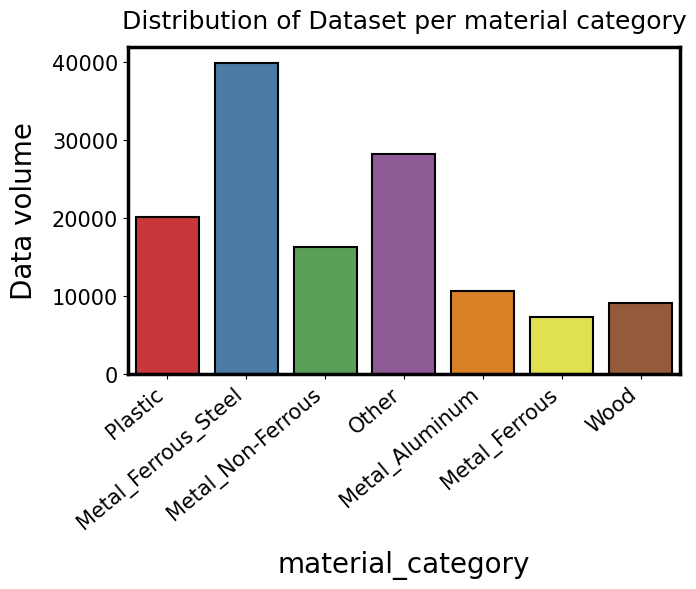

In [18]:
plot_data_distribution(consolidated_dataset, 'material_category', 
                       'Distribution of Dataset per material category', 'material_category_distrubution')

In [19]:
consolidated_dataset['assembly_industries'].unique()

array(['Product Design & Manufacturing',
       'Architecture, Engineering & Construction,Product Design & Manufacturing',
       'Architecture, Engineering & Construction,Product Design & Manufacturing,Other Industries',
       'Architecture, Engineering & Construction',
       'Media & Entertainment',
       'Product Design & Manufacturing,Other Industries',
       'Architecture, Engineering & Construction,Other Industries',
       'Other Industries',
       'Architecture, Engineering & Construction,Media & Entertainment,Product Design & Manufacturing',
       'Media & Entertainment,Other Industries',
       'Media & Entertainment,Product Design & Manufacturing,Other Industries',
       'Civil Infrastructure,Product Design & Manufacturing',
       'Media & Entertainment,Product Design & Manufacturing',
       'Civil Infrastructure,Product Design & Manufacturing,Other Industries',
       'Architecture, Engineering & Construction,Civil Infrastructure,Product Design & Manufacturing,Othe

In [20]:
# len(consolidated_dataset['name'].unique())

# Data Transformation 

Convert the extracted features into a format suitable for feeding into a machine learning model, i.e., a tabular form where each row represents a part and columns represent the feature.

Before feeding the data to a machine learning model, it's essential to preprocess the textual and categorical features to ensure they're in a numerical format. Here's what we can do with those textual information:

- __One-hot Encoding__ for Single Categorical Features: For features like ___assembly_design_type___, which have a single categorical value for each row, can use one-hot encoding. This technique will convert each unique category into a new binary column, where a "1" indicates the presence of that category and a "0" indicates its absence.
- __Multi-label Binarization for multiple categoriacal features__: For features like ___assembly_industries___, which can have multiple values (or labels) in a single row, can use multi-label binarization. This technique will also convert each unique category into a new binary column, similar to one-hot encoding, but it can handle multiple "1s" in the same row.row.

In [22]:
from sklearn.preprocessing import MultiLabelBinarizer

def transform_features(dataset):
    # One-Hot Encoding for 'assembly_design_type'
    # dataset = pd.concat([dataset, pd.get_dummies(dataset['assembly_design_type'], prefix='design_type')], axis=1)
    # dataset.drop(['assembly_design_type'], axis=1, inplace=True)
    
    # Multi-label Binarization for 'assembly_industries'
    # First, split the comma-separated string into a list of labels
    dataset['assembly_industries'] = dataset['assembly_industries'].str.split(',')
    
    mlb = MultiLabelBinarizer()
    industries_encoded = mlb.fit_transform(dataset['assembly_industries'])
    industries_df = pd.DataFrame(industries_encoded, columns=mlb.classes_, index=dataset.index)
    
    # Concatenate the original dataset with the transformed features
    dataset = pd.concat([dataset, industries_df], axis=1)
    dataset.drop(['assembly_industries'], axis=1, inplace=True)
    # dataset.drop(['design_type_ParametricDesignType'], axis=1, inplace=True)
    # dataset.drop(['assembly_filename'], axis=1, inplace=True)
    return dataset

# Apply the transformations
transformed_dataset = transform_features(consolidated_dataset)
transformed_dataset

,center_of_mass_x,center_of_mass_y,center_of_mass_z,body_area,body_volume,material_category,assembly_volume,assembly_mass,assembly_density,,Engineering & Construction,Architecture,Civil Infrastructure,Media & Entertainment,Other Industries,Product Design & Manufacturing
0,9.170593e-16,2.846286,5.060009e-13,1.892846,0.064315,Plastic,0.214475,0.001684,0.00785,0,0,0,0,0,0,1
1,-2.057905e-09,2.423258,-2.936297e-02,0.659531,0.007196,Metal_Ferrous_Steel,0.214475,0.001684,0.00785,0,0,0,0,0,0,1
2,-2.066062e-09,2.421404,6.705135e-01,0.657318,0.007167,Metal_Non-Ferrous,0.214475,0.001684,0.00785,0,0,0,0,0,0,1
3,9.170593e-16,2.846286,7.000000e-01,1.892846,0.064315,Other,0.214475,0.001684,0.00785,0,0,0,0,0,0,1
4,9.170593e-16,2.846286,-7.000000e-01,1.892846,0.064315,Plastic,0.214475,0.001684,0.00785,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131252,6.132067e-01,0.000000,-2.670490e-11,1.729151,0.116680,Metal_Ferrous_Steel,299.830188,2.353667,0.00785,0,0,0,0,0,0,1
131253,0.000000e+00,0.181651,1.007575e-11,0.129364,0.002853,Metal_Ferrous_Steel,299.830188,2.353667,0.00785,0,0,0,0,0,0,1
131254,-6.182051e-17,-0.011000,8.108617e-12,0.016467,0.000024,Metal_Ferrous_Steel,299.830188,2.353667,0.00785,0,0,0,0,0,0,1
131255,0.000000e+00,0.150000,1.045680e-11,0.109956,0.002356,Metal_Ferrous_Steel,299.830188,2.353667,0.00785,0,0,0,0,0,0,1


In [26]:
transformed_dataset.columns

Index(['center_of_mass_x', 'center_of_mass_y', 'center_of_mass_z', 'body_area',
       'body_volume', 'material_category', 'assembly_volume', 'assembly_mass',
       'assembly_density', '', ' Engineering & Construction', 'Architecture',
       'Civil Infrastructure', 'Media & Entertainment', 'Other Industries',
       'Product Design & Manufacturing'],
      dtype='object')

## Split the *train* set into *train* and *validation*

In [23]:
from sklearn.model_selection import train_test_split

# Split the consolidated dataset into train and validation sets
X = transformed_dataset.drop(columns=['material_category'])  # Features excluding the target variable
y = transformed_dataset['material_category']  # Target variable

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

Training set size: 105005
Validation set size: 26252


# Save the transformed dataset

In [24]:
transformed_dataset.to_csv(os.path.join(Feature_PATH, "extracted_feature_v1.csv"))